 # Opis notatnika
 Zmierzamy do końca analizy danych, które zostały nam udostępnione. Ten krok dodaje jeszcze więcej informacji do naszego wyjściowego zbioru. Tym razem sprawdzimy między innymi to, czy opóźnienia lotów zależne są od trasy czy warunków pogodowych.

 Zanim jednak do tego przejdziemy, należy, podobnie jak w poprzednich krokach, skonfigurować odpowiednio notatnik.
 
 W tej części warsztatu ponownie wcielasz się w rolę Analiyka Danych, którego zadaniem jest wykonanie analizy eksplotacyjnej zbioru danych - jedno z wymagań dostarczonych przez klienta.

 Tutaj zaimportuj wymagane biblioteki

In [2]:
import mysql.connector as sql
import pandas as pd
import psycopg2
from psycopg2 import sql
import os
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

 ## Połączenie z bazą danych
 Tutaj uzupełnij konfigurację połączenia

In [3]:
username = ''
password = '' ## trzeba wpisac swoje dane
host = 'localhost'
database= 'airlines'
port = 5432

 Tutaj stwórz zmienną engine, która zostanie użyta do połączenia z bazą danych

In [4]:
url = f'postgresql://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(url)

 Tutaj uzupełnij implementację metody `read_sql_table`

In [5]:
def read_sql_table(table_name, engine, columns=None, 
                   index_col=None, coerce_float=True, parse_dates=None, params=None, chunksize=None):
   
    query = f'SELECT * FROM {table_name}'
   
    
    return pd.read_sql_query(query, engine, index_col=index_col, 
                             coerce_float=coerce_float, parse_dates=parse_dates, params=params, chunksize=chunksize)

 Tutaj zaczytaj zapisaną wcześniej ramkę danych `flight_df` do zmniennej o takiej samej nazwie

In [6]:
flight_df = pd.read_csv("../data/processed/flight_df_02.csv")

 # Wzbogacenie o `airport_list`
 Wczytaj do obszaru roboczego tabelę `airport_list` używając procedury `read_sql_table`. Wykonaj poniższe ćwiczenia:  
 1. Sprawdź, czy klucz `origin_airport_id` jest unikalny, tj. nie ma dwóch takich samych wartości w kolumnie `origin_airport_id`.  
 1. Jeżeli duplikaty występują, usuń je w najdogodniejszy dla Ciebie sposób.  
 1. Jeśli duplikaty nie występują, złącz ramki `airport_list_df` wraz z aktualną `flight_df`, używając kolumny `origin_airport_id` oraz złączenia typu `LEFT JOIN`. Z ramki `airport_list_df` interesuje nas dodanie kolumny `origin_city_name`.  
 1. Dodatkowo dokonaj jeszcze raz złączenia ramki `flight_df` z `airport_list_df`, tym razem jednak złącz kolumnę `destination_airport_id` wraz z `origin_airport_id`. Podobnie jak wcześniej, interesuje nas kolumna `origin_city_name`, jedank ona powinna zostać wyświetlona jako `destination_city_name`

 Tutaj wczytaj ramkę `airport_list_df`

In [7]:
airport_list_df = read_sql_table('airport_list', engine)

 Tutaj sprawdż, czy występują duplikaty dla kolumny `origin_airport_id`

In [8]:
is_origin_airport_id_unique = airport_list_df['origin_airport_id'].is_unique
is_origin_airport_id_unique

True

 Tutaj usuń duplikaty – jeśli występują

In [9]:
airport_list_df = airport_list_df.drop_duplicates(subset=['origin_airport_id'])

In [10]:
airport_list_df.head()

,id,origin_airport_id,display_airport_name,origin_city_name,name
0,1,11638,Fresno Air Terminal,"Fresno, CA","FRESNO YOSEMITE INTERNATIONAL, CA US"
1,2,13342,General Mitchell Field,"Milwaukee, WI","MILWAUKEE MITCHELL AIRPORT, WI US"
2,3,13244,Memphis International,"Memphis, TN","MEMPHIS INTERNATIONAL AIRPORT, TN US"
3,4,15096,Syracuse Hancock International,"Syracuse, NY","SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US"
4,5,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...


 Tutaj dokonaj złączenia ramki `flight_df` oraz `airport_list_df` używając `origin_airport_id`

In [11]:
flight_df = pd.merge(flight_df, airport_list_df[['origin_airport_id', 'origin_city_name']], 
                     how='left', left_on='origin_airport_id', right_on='origin_airport_id')

 Tutaj dokonaj złączenia ramki `flight_df` oraz `airport_list_df` używając `destination_airport_id`

In [12]:
flight_df = pd.merge(flight_df, airport_list_df[['origin_airport_id', 'origin_city_name']],
                     how='left', left_on='dest_airport_id', right_on='origin_airport_id')

In [13]:
flight_df.rename(columns={'origin_city_name_y': 'destination_city_name',
                          'origin_city_name_x': 'origin_city_name',
                          'origin_airport_id_x':'origin_airport_id'
                         }, inplace=True)
flight_df.drop(columns=['origin_airport_id_y'], inplace=True)

In [14]:
flight_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg,origin_city_name,destination_city_name
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,2019,False,True,"[1100, 1200)",2005.0,2004.0,"Atlanta, GA","Denver, CO"
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,NaN,2019,False,True,"[1100, 1200)",2016.0,2016.0,"Atlanta, GA","Denver, CO"
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,0.0,3.0,2019,False,True,"[1100, 1200)",1998.0,1998.0,"Atlanta, GA","Denver, CO"
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,NaN,2019,False,True,"[1100, 1200)",1998.0,1998.0,"Atlanta, GA","Denver, CO"
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,NaN,2019,False,True,"[500, 600)",2001.0,2001.0,"Atlanta, GA","Fort Lauderdale, FL"


### Sprawdzenie
Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [15]:
assert 'origin_city_name' in flight_df.columns, 'Brak kolumny `origin_city_name` w ramce flight_df'
assert 'destination_city_name' in flight_df.columns, 'Brak kolumny `destination_city_name` w ramce flight_df'

flight_df_expected_rows_amount = 1057391
assert flight_df.shape[0] == flight_df_expected_rows_amount, 'Ups, zmieniła się liczba wierszy...'

 ## Analiza według lotnisk oraz tras
 Wykonaj poniższe polecenia:  
 1. Wyznacz lotniska, z których **odlatywało** najwięcej samolotów. Wynik zapisz do ramki `top_airports_origin_df`.
 1. Wyznacz lotnika, na których najwięcej lotów **się kończyło**. Wynik zapisz do ramki `top_airports_destination_df`.  
 1. Wyznacz najczęściej uczęszczaną trasę, wynik zapisz do ramki `top_route_df`.  
 1. Przy założeniu, że reprezentatywna liczba lotów na trasie wynosi ponad 500, wyznacz dodatkowo top 10:  
     - tras z **najmniejszym odsetkiem opóźnień**, wynik zapisz do ramki `least_route_delays_df`.  
     - tras z **największym odsetkiem opóźnień**, wynik zapisz do ramki `top_route_delays_df`.

 Tutaj wyznacz ramkę `top_airports_origin_df`

In [16]:
top_airports_origin_df = flight_df.groupby('origin_airport_id')['id'].count().reset_index()
top_airports_origin_df.rename(columns={'id': 'flight_count'}, inplace=True)
top_airports_origin_df = top_airports_origin_df.sort_values(by='flight_count', ascending=False).head(10)

In [17]:
top_airports_origin_df['origin_city_name'] = flight_df.loc[flight_df['origin_airport_id'].
                                                           isin(top_airports_origin_df['origin_airport_id'])
                                                          ]['origin_city_name'].unique()


In [18]:
top_airports_origin_df

,origin_airport_id,flight_count,origin_city_name
1,10397,123162,"Atlanta, GA"
28,13930,105437,"Denver, CO"
20,12892,87849,"Seattle, WA"
8,11292,64525,"Las Vegas, NV"
21,12953,57708,"Boston, MA"
2,10721,55989,"New York, NY"
33,14747,50465,"Los Angeles, CA"
34,14771,50124,"Dallas/Fort Worth, TX"
9,11298,39511,"San Francisco, CA"
19,12889,38456,"Chicago, IL"


 Tutaj wyznacz ramkę `top_airports_destination_df`

In [19]:
top_airports_destination_df = flight_df.groupby('dest_airport_id')['id'].count().reset_index()
top_airports_destination_df.rename(columns={'id': 'flight_count'}, inplace=True)
top_airports_destination_df = top_airports_destination_df.sort_values(by='flight_count', ascending=False).head(10)

In [20]:
top_airports_destination_df['destination_city_name'] = flight_df.loc[flight_df['dest_airport_id'].
                                                          isin(top_airports_destination_df['dest_airport_id'])
                                                         ]['destination_city_name'].unique()

In [21]:
top_airports_destination_df

,dest_airport_id,flight_count,destination_city_name
1,10397,122945,"Denver, CO"
29,13930,100333,"Los Angeles, CA"
21,12892,87776,"New York, NY"
9,11292,64602,"Boston, MA"
22,12953,57686,"Chicago, IL"
3,10721,56057,"Dallas/Fort Worth, TX"
34,14747,50230,"Seattle, WA"
35,14771,49999,"San Francisco, CA"
10,11298,39488,"Atlanta, GA"
20,12889,38494,"Las Vegas, NV"


 ### Sprawdzenie dla `top_airport_origin`

### Sprawdzenie dla `top_airport_destination`

In [1]:
#  top_airports_destination_head = (top_airports_destination_df
#                                 .sort_values(ascending=False)
#                                  .head()
#                                  .to_list()
#                                  )
# top_airports_destination_head = tuple(top_airports_destination_head)
# top_airports_destination_head_expected = (122945, 100333, 87776, 64602, 57686)

# assert top_airports_destination_head == top_airports_destination_head_expected, f"Nie zgadza się top 5 wierszy, oczekiwano wyników: {top_airports_destination_head_expected} otrzymano: {top_airports_destination_head}"


 # Wzbogacenie o dane pogodowe
 Używając procedury `read_sql_table`, wczytaj tabelę `airport_weather` do ramki `airport_weather_df`. Następnie wykonaj następujące polecenia:  
 1. Pozostaw w ramce tylko następujące kolumny: `['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']`.  
 1. Połącz ramki `airport_list_df` wraz z `airport_weather_df` po odpowiedniej kolumnie używając takiego złączenia, aby w wyniku usunąć te wiersze (lotniska), które nie posiadają danych pogodowych. Dodatkowo, upewnij się, że zostanie tylko dodana kolumna `origin_airport_id`.

 Tutaj wczytaj ramkę `airport_weather`

In [23]:
airport_weather_df = read_sql_table('airport_weather', engine)

 Tutaj oczyść ramkę `airport_weather_df` z nadmiarowych kolumn

In [24]:
selected_columns = ['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']
airport_weather_df = airport_weather_df[selected_columns]

 Tutaj połącz ramki `airport_list_df` oraz `airport_weather_df` aktualizując `airport_weather_df`

In [25]:
airport_weather_df = pd.merge(airport_list_df[['origin_airport_id', 'name']], airport_weather_df, 
                                      how='inner', left_on='name', right_on='name')

In [26]:
airport_weather_df.head(1)

,origin_airport_id,name,station,date,prcp,snow,snwd,tmax,awnd
0,11638,"FRESNO YOSEMITE INTERNATIONAL, CA US",USW00093193,2019-01-01,0.0,0.0,0.0,50.0,3.13


 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [27]:
airport_weather_df_expected_shape = (43394, 9)
airport_weather_df_shape = airport_weather_df.shape

assert airport_weather_df_expected_shape == airport_weather_df_shape, \
  f'Nieodpowiedni wymiar ramki airport_weather_df, oczekiwano (wierszy, kolumn): {airport_weather_df_expected_shape}'


 ## Połączenie `airport_weather_df` oraz `flight_df`
 W celu złączenia ramek `airport_weather_df` oraz `flight_df` wykonaj następujące kroki:  
 1. w ramce `aiport_weather_df` występuje kolumna `date`, zrzutuj ją na typ `DATETIME`.  
 1. w ramce `flight_df` należy stworzyć nową kolumnę o nazwie `date`. W tym celu:  
 	- złącz kolumny `month`, `day_of_month` oraz `year` razem, użyj następującego formatu daty: `YYYY-MM-DD`.
 	- zrzutuj kolumnę `date` na typ `DATETIME`.  
 1. złącz ramki używając odpowiedniego klucza, wynik złączenia zapisz do ramki `flight_df`. Użyj złącznia typu `LEFT JOIN`.

 > Dlaczego istotne jest zachowanie typów przy złączeniu?

W trakcie pracy możesz posłużyć się następującymi artykułami z `LMS`:
 - `Python - analiza danych > Dzień 6 - Pandas > Merge`
 - `Python - analiza danych > Dzień 6 - Pandas > Praca z datetime`
 - Dokumentacje metody `to_datetime`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)
 - Dostępne formaty dat: [klik](https://www.programiz.com/python-programming/datetime/strftime) - sekcja `Format Code List`

 Tutaj zrzutuj kolumnę `date` na `DATETIME` w ramce `airport_weather_df`

In [28]:
airport_weather_df['date'] = pd.to_datetime(airport_weather_df['date'])

In [29]:
airport_weather_df

,origin_airport_id,name,station,date,prcp,snow,snwd,tmax,awnd
0,11638,"FRESNO YOSEMITE INTERNATIONAL, CA US",USW00093193,2019-01-01,0.00,0.0,0.0,50.0,3.13
1,11638,"FRESNO YOSEMITE INTERNATIONAL, CA US",USW00093193,2019-01-02,0.00,0.0,0.0,55.0,1.12
2,11638,"FRESNO YOSEMITE INTERNATIONAL, CA US",USW00093193,2019-01-03,0.00,0.0,0.0,59.0,2.01
3,11638,"FRESNO YOSEMITE INTERNATIONAL, CA US",USW00093193,2019-01-04,0.00,0.0,0.0,64.0,2.68
4,11638,"FRESNO YOSEMITE INTERNATIONAL, CA US",USW00093193,2019-01-05,0.30,0.0,0.0,57.0,7.38
...,...,...,...,...,...,...,...,...,...
43389,10693,"NORTH MYRTLE BEACH, SC US",USW00093718,2020-03-27,0.00,NaN,NaN,75.0,12.30
43390,10693,"NORTH MYRTLE BEACH, SC US",USW00093718,2020-03-28,0.00,NaN,NaN,77.0,13.87
43391,10693,"NORTH MYRTLE BEACH, SC US",USW00093718,2020-03-29,0.00,NaN,NaN,80.0,13.87
43392,10693,"NORTH MYRTLE BEACH, SC US",USW00093718,2020-03-30,0.00,NaN,NaN,80.0,5.82


 Tutaj stwórz kolumnę `date` w ramce `flight_df`. Pamiętaj, aby była ona również typu `DATETIME`.

In [30]:
flight_df['date'] = pd.to_datetime(flight_df[['year', 'month', 'day_of_month']].astype(str).agg('-'.join, axis=1))

flight_df['date'] = pd.to_datetime(flight_df['date'])

In [31]:
flight_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,late_aircraft_delay,year,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg,origin_city_name,destination_city_name,date
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,2019,False,True,"[1100, 1200)",2005.0,2004.0,"Atlanta, GA","Denver, CO",2019-01-20
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,2019,False,True,"[1100, 1200)",2016.0,2016.0,"Atlanta, GA","Denver, CO",2019-01-20
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,3.0,2019,False,True,"[1100, 1200)",1998.0,1998.0,"Atlanta, GA","Denver, CO",2019-01-20
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,2019,False,True,"[1100, 1200)",1998.0,1998.0,"Atlanta, GA","Denver, CO",2019-01-20
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,2019,False,True,"[500, 600)",2001.0,2001.0,"Atlanta, GA","Fort Lauderdale, FL",2019-01-20


 Tutaj złącz tabeli `airport_weather_df` oraz `flight_df`

In [32]:
flight_df

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,late_aircraft_delay,year,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg,origin_city_name,destination_city_name,date
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,2019,False,True,"[1100, 1200)",2005.0,2004.0,"Atlanta, GA","Denver, CO",2019-01-20
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,2019,False,True,"[1100, 1200)",2016.0,2016.0,"Atlanta, GA","Denver, CO",2019-01-20
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,3.0,2019,False,True,"[1100, 1200)",1998.0,1998.0,"Atlanta, GA","Denver, CO",2019-01-20
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,2019,False,True,"[1100, 1200)",1998.0,1998.0,"Atlanta, GA","Denver, CO",2019-01-20
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,2019,False,True,"[500, 600)",2001.0,2001.0,"Atlanta, GA","Fort Lauderdale, FL",2019-01-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057386,1382967,12,11,3,DL,N321DH,1826,13303,10397,1807,...,NaN,2019,False,False,"[500, 600)",2017.0,2016.0,"Miami, FL","Atlanta, GA",2019-12-11
1057387,1382968,12,11,3,DL,N329NW,1982,13303,12953,1959,...,0.0,2019,True,False,"[1000, 1100)",1992.0,1992.0,"Miami, FL","New York, NY",2019-12-11
1057388,1382969,12,11,3,DL,N331NW,1987,13303,10397,1125,...,NaN,2019,False,False,"[500, 600)",1992.0,1992.0,"Miami, FL","Atlanta, GA",2019-12-11
1057389,1382970,12,11,3,DL,N309DN,2151,13303,12953,700,...,0.0,2019,True,False,"[1000, 1100)",2016.0,2016.0,"Miami, FL","New York, NY",2019-12-11


In [33]:
flight_df = flight_df.sort_values('date') ## 3 dni
airport_weather_df = airport_weather_df.sort_values('date')

In [34]:
flight_df = pd.merge_asof(flight_df, airport_weather_df, on='date')

In [35]:
flight_df

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id_x,dest_airport_id,crs_dep_time,...,destination_city_name,date,origin_airport_id_y,name,station,prcp,snow,snwd,tmax,awnd
0,1130866,1,1,2,UA,N78511,390,14679,14771,1113,...,"San Francisco, CA",2019-01-01,12264,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",USW00093738,0.0,0.0,0.0,62.0,12.30
1,167573,1,1,2,UA,N38467,948,11292,14747,1529,...,"Seattle, WA",2019-01-01,12264,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",USW00093738,0.0,0.0,0.0,62.0,12.30
2,167574,1,1,2,UA,N75432,830,11292,13930,1658,...,"Chicago, IL",2019-01-01,12264,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",USW00093738,0.0,0.0,0.0,62.0,12.30
3,167575,1,1,2,UA,N12238,744,11292,12892,1411,...,"Los Angeles, CA",2019-01-01,12264,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",USW00093738,0.0,0.0,0.0,62.0,12.30
4,167576,1,1,2,UA,N75425,739,11292,14107,1152,...,"Phoenix, AZ",2019-01-01,12264,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",USW00093738,0.0,0.0,0.0,62.0,12.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057386,1072448,12,31,2,AA,N940NN,2691,14771,13930,900,...,"Chicago, IL",2019-12-31,11423,"DES MOINES INTERNATIONAL AIRPORT, IA US",USW00014933,0.0,0.0,0.0,35.0,14.09
1057387,121238,12,31,2,NK,N510NK,877,10397,11697,1000,...,"Fort Lauderdale, FL",2019-12-31,11423,"DES MOINES INTERNATIONAL AIRPORT, IA US",USW00014933,0.0,0.0,0.0,35.0,14.09
1057388,869281,12,31,2,WN,N8698B,6512,12892,10397,1450,...,"Atlanta, GA",2019-12-31,11423,"DES MOINES INTERNATIONAL AIRPORT, IA US",USW00014933,0.0,0.0,0.0,35.0,14.09
1057389,121207,12,31,2,NK,N604NK,251,10397,13204,2059,...,"Orlando, FL",2019-12-31,11423,"DES MOINES INTERNATIONAL AIRPORT, IA US",USW00014933,0.0,0.0,0.0,35.0,14.09


 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [36]:
flight_df_expected_rows_amount = 1057391
assert flight_df.shape[0] == flight_df_expected_rows_amount, 'Ups, zmieniła się liczba wierszy...'

# Praca samodzielna
Używając `flight_df` zbadaj hipotezę o tym, że temperatura maksymalna wpływa na **odsetek** opóźnień lotów (kolumna `tmax`).  

Przy wykonywaniu tego zadania masz pełną dowolność, jednak powinno składać się conajmniej z następujących elementów:
- sprawdzenie, czy zmienna posiada obserwacje odstające,
- oczyszczenie danych o ile konieczne,
- przedstawienie w formie tabeli czy wzrost danej zmiennej powoduje zmianę w odsetku opóźnień lotów,
- wizualizację stworzonej wcześniej tabeli w formie wykresu,
- krótkiego opisu wyników w komórce markdown.

 ## Analiza dla kolumny `tmax`

count    1057391.00
mean          71.60
std           18.14
min            8.00
10%           46.00
25%           60.00
50%           75.00
75%           85.00
90%           91.00
95%           96.00
99%          107.00
max          113.00
Name: tmax, dtype: float64


<Axes: xlabel='tmax'>

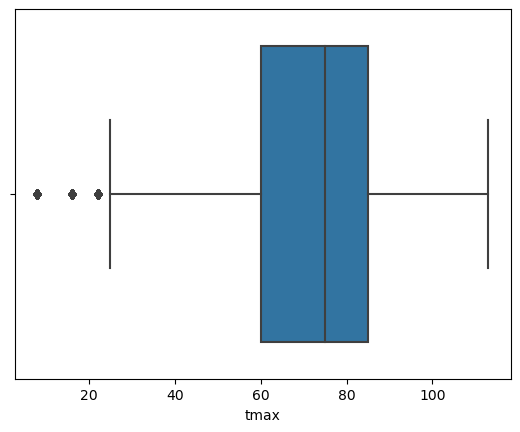

In [37]:
tmax_stats = flight_df['tmax'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)
print(tmax_stats)

sns.boxplot(x=flight_df['tmax'])

In [81]:
test_temp_df = flight_df[flight_df['tmax'] <= 57].copy()
test_temp_df['tmax'] = test_temp_df['tmax'].round(0).astype(int)
bins = np.arange(0, test_temp_df['tmax'].max() + 5, 5).round(0)
test_temp_df['tmax_range'] = pd.cut(test_temp_df['tmax'], bins, right=False)

temperature_delay_count = test_temp_df.groupby('tmax_range')['is_delayed'].sum().reset_index()

temperature_delay_count['tmax_range'] = temperature_delay_count['tmax_range'].astype(str)

print(temperature_delay_count)

   tmax_range  is_delayed
0      [0, 5)           0
1     [5, 10)         749
2    [10, 15)           0
3    [15, 20)         615
4    [20, 25)         695
5    [25, 30)        3587
6    [30, 35)        2311
7    [35, 40)        7462
8    [40, 45)        4584
9    [45, 50)        3616
10   [50, 55)       13431
11   [55, 60)        5445


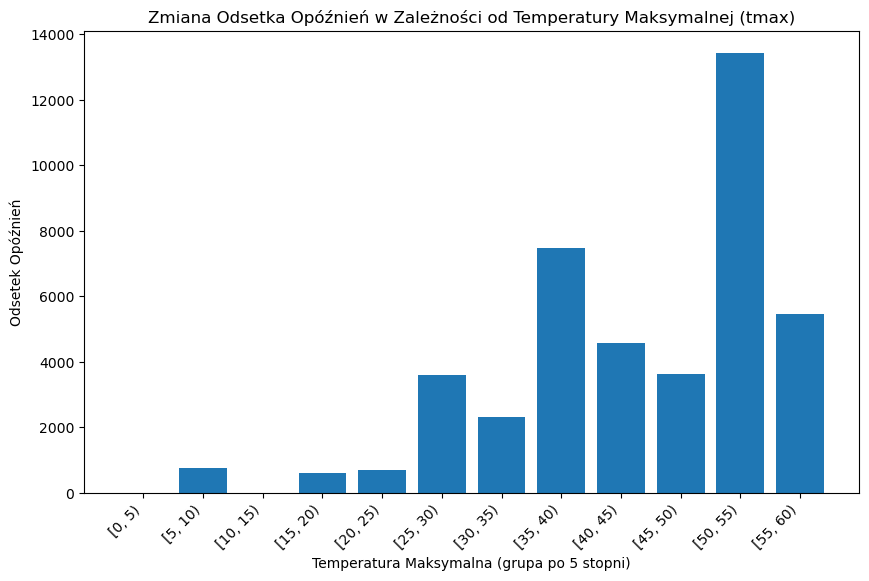

In [83]:
plt.figure(figsize=(10, 6))
plt.bar(x=temperature_delay_count['tmax_range'], height=temperature_delay_count['is_delayed'])
plt.title('Zmiana Odsetka Opóźnień w Zależności od Temperatury Maksymalnej (tmax)')
plt.xlabel('Temperatura Maksymalna (grupa po 5 stopni)')
plt.ylabel('Odsetek Opóźnień')
plt.xticks(rotation=45, ha='right')
plt.show()

## Miejsce na Twój komentarz

In [ ]:
## wzrost temperatury wpływa na odsetek opóźnień lotów. 

# Podsumowanie
W tej części warsztatu dokonaliśmy kompleksowej analizy posiadanego zbioru danych. Eksploracja
pozwoliła nam na zapoznanie się z cechami charakterystycznymi lotów - wiemy już, które 
zmienne mogą mieć wpływ na opóźnienia lotów, a które nie. Co warto podkreślić, skupiliśmy się na wielu
aspektach tej analizy, co otwiera potencjalnie również inne możliwości dalszej pracy nad tą bazą.

W tym momencie przejdziemy do kolejnego kroku, w którym, na podstawie tej analizy, przygotujemy 
system raportowy. Zanim jednak stworzymy dashboard, potrzebujemy zaktualizować naszą bazę danych.

In [84]:
flight_df.to_csv('../data/processed/flight_df_03.csv', index=False)